In [152]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [153]:
q = '''select advisory_id, package_id, ecosystem, type, severity, disclose_date, publish_date,
       fix_commit_date, release_date, version
        from
        (select advisory_id, min(commit_date) as fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id;'''
df = pd.DataFrame(sql.execute(q))
df['fix_to_release_delay'] = (df['release_date'] - df['fix_commit_date']).dt.total_seconds()
df['fix_to_release_delay'] = round ( df['fix_to_release_delay'] / (3600 * 24))
df['disclose_to_fix_delay'] = (df['fix_commit_date'].dt.date - df['disclose_date']).dt.days
df['release_to_publish_delay'] = (df['publish_date'] - df['release_date'].dt.date).dt.days
df['fix_to_publish_delay'] = (df['publish_date'] - df['fix_commit_date'].dt.date).dt.days
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,fix_commit_date,release_date,version,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay
0,SNYK-PYTHON-SALT-174927,1,pip,Arbitrary Code Execution,H,2013-05-11,2019-06-06,2013-09-19 18:27:38,2013-10-17 18:17:40,0.17.1,28.0,131,2058,2086
1,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-09 16:33:50,2016.11.8,39.0,7,27,66
2,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-09 16:30:36,2016.3.8,39.0,7,27,66
3,SNYK-PYTHON-SALT-40687,1,pip,Denial of Service (DoS),H,2017-08-24,2017-11-05,2017-08-31 17:07:42,2017-10-09 16:39:22,2017.7.2,39.0,7,27,66
4,SNYK-PYTHON-SALT-40688,1,pip,Directory Traversal,H,2017-08-23,2017-11-05,2017-08-31 17:06:33,2017-10-09 16:33:50,2016.11.8,39.0,8,27,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,0.0,0,1,1
2734,SNYK-PHP-LIGHTSAMLLIGHTSAML-72139,2335,Composer,Access Restriction Bypass,H,2018-04-18,2018-04-26,2018-03-05 16:26:57,2018-03-05 16:29:08,1.3.5,0.0,-44,52,52
2735,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,0.0,0,0,0
2736,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,2019-01-22 08:42:56,2019-01-22 10:12:04,9.5.4,0.0,0,0,0


In [154]:
total = len(df)
d2f = df[df['disclose_to_fix_delay'] > 0]
before = len(d2f)
d2f['disclose_to_fix_delay'].describe(), before/total


(count     696.000000
 mean       71.550287
 std       185.770603
 min         1.000000
 25%         1.000000
 50%         7.000000
 75%        39.500000
 max      1849.000000
 Name: disclose_to_fix_delay, dtype: float64,
 0.254200146092038)

In [155]:
df['release_to_publish_delay'].describe()

count    2738.000000
mean      178.871804
std       464.463902
min     -1756.000000
25%         1.000000
50%        11.000000
75%       132.000000
max      4918.000000
Name: release_to_publish_delay, dtype: float64

In [156]:
wrong = df[df['fix_to_release_delay'] < 0]
wrong.to_csv('delaylessthanzero.csv', index=False)

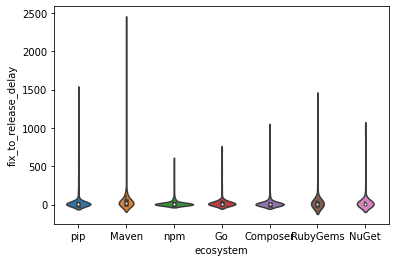

In [157]:
df= df[df['fix_to_release_delay'] >= 0]
ax = sns.violinplot(y='fix_to_release_delay', x='ecosystem', data = df)
plt.savefig('fix_to_release_delay.png')

In [158]:
gb = df.groupby('ecosystem')
eco_dfs = [(x,gb.get_group(x)) for x in gb.groups]
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
pkg = df.groupby('ecosystem')[['package_id']].nunique()
rel = df.groupby('ecosystem')[['advisory_id']].count()
fixrel = df.groupby('ecosystem')[['fix_to_release_delay']].median()
pub_before_release = df[df['release_to_publish_delay']<0]
pub_before_release = pub_before_release.groupby('ecosystem')[['advisory_id']].count()
pub_before_fix = df[df['fix_to_publish_delay']<0]
pub_before_fix = pub_before_fix.groupby('ecosystem')[['advisory_id']].count()


In [159]:
final =reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[adv, pkg, rel, fixrel,pub_before_release, pub_before_fix])
final = final.reset_index()
final.columns = ['ecosystem','advisory','package','releases','fix_to_release', 'publish_before_release','publish_before_fix']
final['publish_before_release'] =  round(final['publish_before_release'] / final['releases'] * 100, 1)
final['publish_before_fix'] =  round(final['publish_before_fix'] / final['releases'] * 100, 1)
final['temp'] = final['ecosystem'].str.lower()
final = final.sort_values(by = 'temp', ascending=True)
final = final.drop('temp', axis=1)
final

,ecosystem,advisory,package,releases,fix_to_release,publish_before_release,publish_before_fix
0,Composer,183,93,295,1.0,8.5,3.7
1,Go,184,150,242,7.0,19.8,8.3
2,Maven,531,349,760,16.0,19.5,3.9
5,npm,553,412,640,1.0,23.0,8.9
3,NuGet,70,22,75,4.0,6.7,5.3
6,pip,324,200,442,6.0,19.2,9.7
4,RubyGems,113,80,139,7.0,7.2,2.9


In [160]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrrrr}
\hline
 ecosystem   &   advisory &   package &   releases &   fix\_to\_release &   publish\_before\_release &   publish\_before\_fix \\
\hline
 Composer    &        183 &        93 &        295 &                1 &                      8.5 &                  3.7 \\
 Go          &        184 &       150 &        242 &                7 &                     19.8 &                  8.3 \\
 Maven       &        531 &       349 &        760 &               16 &                     19.5 &                  3.9 \\
 npm         &        553 &       412 &        640 &                1 &                     23   &                  8.9 \\
 NuGet       &         70 &        22 &         75 &                4 &                      6.7 &                  5.3 \\
 pip         &        324 &       200 &        442 &                6 &                     19.2 &                  9.7 \\
 RubyGems    &        113 &        80 &        139 &                7 &                      7

In [161]:
# q='select * from fix_commits where commit_date is not null'
# df = pd.DataFrame(sql.execute(q))
# df['auth_commit_delay'] = (df['commit_date'].dt.date - df['author_date'].dt.date).dt.days
# df['auth_commit_delay'].describe()
# print(len(df))
# df = df[df['auth_commit_delay'] > 0]
# len(df)

In [162]:
high, medium, low = df[df['severity']=='H'], df[df['severity']=='M'], df[df['severity']=='L']
high['fix_to_release_delay'].describe(), medium['fix_to_release_delay'].describe(), low['fix_to_release_delay'].describe()

(count    1140.000000
 mean       33.434211
 std       109.144161
 min         0.000000
 25%         0.000000
 50%         6.000000
 75%        21.250000
 max      1758.000000
 Name: fix_to_release_delay, dtype: float64,
 count    1324.000000
 mean       38.601208
 std       119.391774
 min         0.000000
 25%         0.000000
 50%         6.000000
 75%        28.250000
 max      1734.000000
 Name: fix_to_release_delay, dtype: float64,
 count     129.000000
 mean       51.635659
 std       250.196733
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        14.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64)

In [163]:

from scipy.stats import mannwhitneyu
mannwhitneyu(high['fix_to_release_delay'],medium['fix_to_release_delay']), mannwhitneyu(high['fix_to_release_delay'],low['fix_to_release_delay']), mannwhitneyu(medium['fix_to_release_delay'],low['fix_to_release_delay'])

(MannwhitneyuResult(statistic=732369.0, pvalue=0.099785465848022),
 MannwhitneyuResult(statistic=71265.5, pvalue=0.28056308322966617),
 MannwhitneyuResult(statistic=80047.5, pvalue=0.11706022517540154))

In [164]:
q = '''select advisory_id, package_id, ecosystem, min(release_date) as first,
       max(release_date) as last
        from
        (select advisory_id, min(commit_date) as fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where ecosystem = 'npm'
        and commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where ecosystem = 'npm'
        and type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id
            and fcd.advisory_id in
    (select advisory_id from
(select advisory_id, count(*)
from
(select advisory_id, min(commit_date) as fix_commit_date
from fix_commits fc
join package p on fc.package_id = p.id
where ecosystem = 'npm'
and commit_date is not null
group by advisory_id) as fcd
join
(select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where ecosystem = 'npm'
and type != 'Malicious Package'
and fr.version!= 'manual checkup needed'
    and ri.publish_date is not null) as frd
on fcd.advisory_id=frd.id
group by advisory_id
having count(*) > 1) as sub) 
group by advisory_id, package_id, ecosystem;'''
multiple_rel = pd.DataFrame(sql.execute(q))
multiple_rel['range'] = (multiple_rel['last'].dt.date - multiple_rel['first'].dt.date).dt.days
multiple_rel['range'].describe()

count      57.000000
mean       41.508772
std       156.849350
min         0.000000
25%         0.000000
50%         4.000000
75%         9.000000
max      1130.000000
Name: range, dtype: float64

In [165]:
q='''select id as advisory_id,
       case
        when id in (select advisory_id from advisoryCVE) then 'cve'
        else 'noncve'
end as ifcve
from advisory;'''
ifcve = pd.DataFrame(sql.execute(q))
print(len(df), len(ifcve))
df= pd.merge(df, ifcve, on='advisory_id')
len(df)

2593 6956


2593

In [166]:
cve = df[df['ifcve']=='cve']
noncve = df[df['ifcve']=='noncve']
print(len(cve), len(noncve))

1961 632


In [167]:
cve['fix_to_release_delay'].describe(), noncve['fix_to_release_delay'].describe()

(count    1961.000000
 mean       30.691994
 std       111.976897
 min         0.000000
 25%         0.000000
 50%         6.000000
 75%        22.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64,
 count     632.000000
 mean       56.482595
 std       157.188773
 min         0.000000
 25%         0.000000
 50%         6.000000
 75%        35.500000
 max      1341.000000
 Name: fix_to_release_delay, dtype: float64)

In [168]:
mannwhitneyu(cve['fix_to_release_delay'],noncve['fix_to_release_delay'].describe())

MannwhitneyuResult(statistic=4942.5, pvalue=0.03379194881996541)